# Summarize provided data

In this notebook, the input data for the modeling challenge is summarized and plotted.

*R.A. Collenteur, Eawag, 21st of December, 2023*

### 0. Load the necessary packages

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

from matplotlib.gridspec import GridSpec
ps.set_log_level("ERROR")

### 1. store start and end of validation period

In [2]:
# Start and end of validation period

tmin = {
    "Netherlands": "2016-09-23",
    "USA": "2017-01-18",
    "Germany": "2017-01-01",
    #"Sweden_1": "2016-01-05",
    "Sweden_2": "2016-01-05",
}

tmax = {
    "Netherlands": "2020-11-27",
    "USA": "2021-12-31",
    "Germany": "2021-12-31",
    #"Sweden_1": "2020-12-29",
    "Sweden_2": "2020-12-29",
}

### 2. Load the data

In [3]:
sims = pd.read_csv("../data/all_results.csv", index_col=0, parse_dates=True, header=[0, 1, 2])

wells = sims.columns.get_level_values(1).unique().drop("Sweden_1")
names = ['Netherlands', 'Germany', 'Sweden', 'USA']

heads = []
for well in wells:
    head = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                       index_col=0, parse_dates=True).squeeze().dropna()
    head.index = head.index.round("D")    
    head.name = well
    heads.append(head.loc[~head.index.duplicated()])

heads = pd.concat(heads, axis=1)
heads = heads.loc[~heads.index.duplicated()]

### 3. Figure 01: Summary plot of the head data

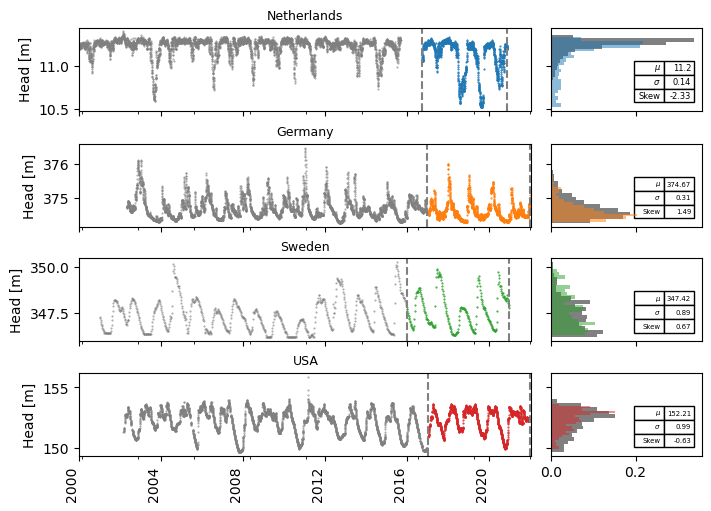

In [4]:
fig = plt.figure(figsize=(7,5), constrained_layout=True)

gs = GridSpec(4, 4, figure=fig)

ts_axes = []
kde_axes = []
map_axes = []
ts_ax = None

for i in range(4):
    if ts_ax is None:
        ts_ax = fig.add_subplot(gs[i, 0:3])
        kde_ax = fig.add_subplot(gs[i, 3], sharey=ts_ax)
    else:
        ts_ax = fig.add_subplot(gs[i, 0:3], sharex=ts_axes[0])
        kde_ax = fig.add_subplot(gs[i, 3], sharey=ts_ax, sharex=kde_axes[0])
        
    ts_axes.append(ts_ax)
    kde_axes.append(kde_ax)
    
    #ax = fig.add_subplot(gs[i, 4])
    #map_axes.append(ax)
    #ax.set_yticks([])
    #ax.set_xticks([])

for i, (well, ax) in enumerate(zip(wells, ts_axes)):
    heads.loc[:tmin[well], well].plot(ax=ax, color="gray", marker=".", markersize=1, linestyle=" ", alpha=0.7)
    heads.loc[tmin[well]:tmax[well], well].plot(ax=ax, marker=".", markersize=1, linestyle=" ", color="C{}".format(i))
    ax.set_title(names[i], fontsize=9)
    ax.set_ylabel("Head [m]")

    df = heads.loc[:tmin[well], well].dropna()
    df.hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="gray",
        bins=20,
        grid=False,
        alpha=1,
        weights = np.ones_like(df.values) / df.index.size
    )
    
    df = heads.loc[tmin[well]:tmax[well], well].dropna()
    df.hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="C{}".format(i),
        bins=20,
        grid=False,
        alpha=0.5,
        weights = np.ones_like(df.values) / df.index.size
    )

    table = [["$\mu$", heads.loc[:, well].mean().round(2)],
             ["$\sigma$", round(heads.loc[:, well].std(), 2)],
             ["Skew", heads.loc[:, well].skew().round(2)]]
    kde_axes[i].table(table, bbox=[0.55, 0.1, 0.4, 0.5])
    
    #map_axes[i].plot(1,1)
    
    ax.axvline(tmin[well], color="gray", linestyle="--")
    ax.axvline(tmax[well], color="gray", linestyle="--")    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

ax.set_xlim("2000", "2022-01-31")

plt.savefig("../figures/figure_01.png", bbox_inches="tight", dpi=300)

### 4. Table 01: Summary statistics table of stresses

In [5]:
table = pd.DataFrame(index=names, columns=["Climate", "Avg. yearly T ($\degree$C)", "Avg. yearly P (mm)", "Avg. yearly ET$_p$ (mm)"])
table.loc[:, "Climate"] = ["Cfb", "Dfb", "Dfc", "Dfb"]

for name in ['Netherlands', 'Germany', 'Sweden_2']:
    df = pd.read_csv("../data/{}/input_data.csv".format(name), index_col=0, parse_dates=True)
    name = name.split("_")[0]
    table.loc[name, ["Avg. yearly P (mm)", "Avg. yearly ET$_p$ (mm)"]] = df.loc[:, ["rr", "et"]].resample("A").sum().mean().round(0).values
    table.loc[name, "Avg. yearly T ($\degree$C)"] = df.loc[:, "tg"].resample("A").mean().mean().round(1)

df = pd.read_csv("../data/USA/input_data.csv", index_col=0, parse_dates=True)
table.loc["USA", ["Avg. yearly P (mm)", "Avg. yearly ET$_p$ (mm)"]] = df.loc[:, ["PRCP", "ET"]].resample("A").sum().mean().round(0).values
table.loc["USA", "Avg. yearly T ($\degree$C)"] = df.loc[:, ["TMIN", "TMAX"]].mean(axis=1).resample("A").mean().mean().round(1)

with open("table_01.tex", mode="w") as file:
    file.write(table.to_latex(float_format="%.2f", bold_rows=True).replace("\\toprule", "\\tophline").replace("\\midrule", "\\middlehline").replace("\\bottomrule", "\\bottomhline"))
table

,Climate,Avg. yearly T ($\degree$C),Avg. yearly P (mm),Avg. yearly ET$_p$ (mm)
Netherlands,Cfb,9.9,876.0,559.0
Germany,Dfb,8.7,692.0,641.0
Sweden,Dfc,0.0,353.0,332.0
USA,Dfb,8.9,1344.0,956.0
